In [165]:
import tensorflow as tf
import json
import numpy as np
import pandas as pd

from google.cloud import bigquery
from google.cloud import storage

from google.cloud import aiplatform


import matplotlib.pyplot as plt
import seaborn as sns
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/custom-tabular-bq-managed-dataset.ipynb

In [166]:
print(tf.__version__)

2.11.0


In [169]:
#table_id='new_incident'
#table_id='test_incident'
table_id='validation_incident'

projectId='smart-data-ml'
dataset_id='SMartML'
REGION="asia-southeast1"

if  table_id=='new_incident':
 unUsedColtoPredict=['severity','id','severity_id','severity_name','imported_at']
 filePath='../../data/Prediction_New_Incident.csv'
elif table_id=='test_incident' or table_id=='validation_incident':
 unUsedColtoPredict=['severity','id','severity_id','severity_name']  
 filePath=f'../../data/Prediction_{table_id}.csv'
    
isLocalModel=True

isBQToCSV=True


modelFile_endPoint=1 
#1=local(dev)/gcs(clound function) and 2=vertext

localFile=True


In [170]:
from google.oauth2 import service_account
mycredentials = service_account.Credentials.from_service_account_file(r'C:\Windows\smart-data-ml-91b6f6204773.json')

if isBQToCSV:
    
    
    bqclient= bigquery.Client(project=projectId,credentials=mycredentials)
    def download_table(bq_table_uri: str):

        prefix = "bq://"
        if bq_table_uri.startswith(prefix):
            bq_table_uri = bq_table_uri[len(prefix) :]

        table = bigquery.TableReference.from_string(bq_table_uri)
        rows = bqclient.list_rows(table)
        return rows.to_dataframe()

    dfNewData=download_table(f"{projectId}.{dataset_id}.{table_id}")
    dfNewData.to_csv(filePath,index=False)    
    print(dfNewData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_id                217 non-null    Int64  
 1   severity_name              217 non-null    object 
 2   sla                        217 non-null    object 
 3   product_type               217 non-null    object 
 4   brand                      217 non-null    object 
 5   service_type               217 non-null    object 
 6   incident_type              217 non-null    object 
 7   open_to_close_hour         217 non-null    float64
 8   response_to_resolved_hour  217 non-null    float64
 9   label_multi_severity       217 non-null    Int64  
 10  label_binary_severity      217 non-null    Int64  
dtypes: Int64(3), float64(2), object(6)
memory usage: 19.4+ KB
None



# Load and Map Data Test

In [171]:
if  localFile:
    dfNewData=pd.read_csv(filePath)

# dfNewData=dfNewData.sample(3)

In [172]:
mapping_file="incident_sevirity_to_class.json"

def download_map_severity_class_as_dict():
 
    storage_client = storage.Client()
    buckdfNewData = storage_client.bucket("smart-ml-pongthorn")
    blob = bucket.blob(mapping_file)
    blob.download_to_filename(mapping_file)
    with open(mapping_file, 'r') as file:
            return json.loads(file.read())

if  localFile==False:    
    map_sevirity_to_class= download_map_severity_class_as_dict()
else:
   with open(mapping_file, 'r') as json_file:
     map_sevirity_to_class= json.load(json_file)
                                  
                                  
print(map_sevirity_to_class)


{'Cosmatic': 0, 'Minor': 1, 'Major': 2, 'Critical': 3}


In [173]:
if table_id=='new_incident':
    
    dfNewData.insert(2, 'severity', dfNewData['severity_name'].map(map_sevirity_to_class),True)
    print(dfNewData.info())
elif table_id=='test_incident' or table_id=='validation_incident':
    
    dfNewData=dfNewData.rename(columns={'label_multi_severity':'severity'})
    dfNewData=dfNewData.drop(columns=['label_binary_severity'])
    if 'id' not in dfNewData.columns.to_list():
        dfNewData=dfNewData.reset_index(drop=True)
        dfNewData = dfNewData.reset_index(level=0)
        dfNewData.rename(columns={"index": "id"},inplace=True)
        dfNewData['id']=dfNewData['id']+1
print(filePath)      
dfNewData.tail()

../../data/Prediction_validation_incident.csv


,id,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,severity
212,213,2,Major,24x7 4Hrs Response Time,Firewall,Palo Alto,Incident,Software,889.683333,888.966667,2
213,214,3,Minor,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,General Incident,30.233333,30.166667,1
214,215,4,Cosmatic,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,76.283333,1.316667,0
215,216,4,Cosmatic,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,21.333333,2.800000,0
216,217,4,Cosmatic,24x7 6Hrs Resolution Time,Software,Trend Micro,Request,General Incident,4.666667,4.483333,0


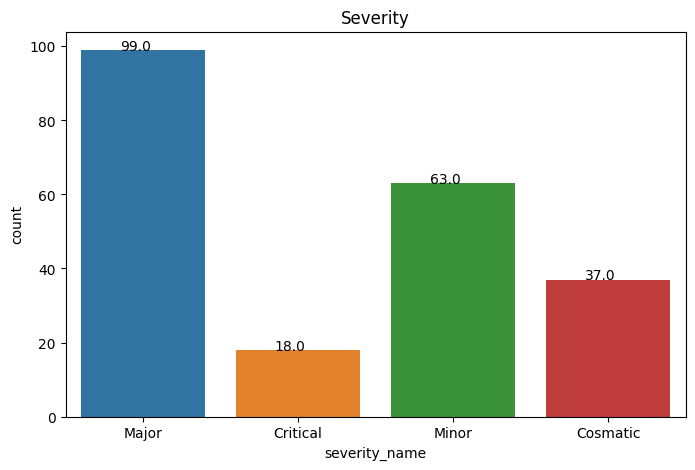

In [174]:
def plot_class(df):
    fig , ax = plt.subplots(figsize=(8,5))
    ax =sns.countplot(x='severity_name', data=df,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title('Severity')
    plt.show()
    
plot_class(dfNewData)

In [175]:
pdPrediction=pd.DataFrame(columns=['_id','_predict_severity'])
pdPrediction

,_id,_predict_severity


# Load Model from Directory to Predict

In [176]:
if modelFile_endPoint==1 :

    if  isLocalModel: # Window Enviroment
        PATH_FOLDER_ARTIFACTS="model"    
    else: # For running on Vertex AI Notebook t
        PATH_FOLDER_ARTIFACTS="gs://tf1-incident-pongthorn/model"

    model = tf.keras.models.load_model(PATH_FOLDER_ARTIFACTS)    
    print(f"Load from {PATH_FOLDER_ARTIFACTS}")
    # model.summary()

    
    for  row_dict in dfNewData.to_dict(orient="records"):
          incident_id=row_dict['id']
          print(f"{incident_id} - {row_dict['severity']}({row_dict['severity_name']})") 
          for key_removed in unUsedColtoPredict:
           row_dict.pop(key_removed)
          # print(row_dict)  

          input_dict = {name: tf.convert_to_tensor([value]) for name, value in row_dict.items()}


          predictionResult = model.predict(input_dict)
          # print(f"{predictionResult}")   
          # maxResult=np.max(arryResult)
          # maxResult=round( maxResult,4)
          # print(f"{maxResult} of {arryResult}")

          prob = tf.nn.softmax(predictionResult)
          prob_pct=(100 * prob)  
          _class = tf.argmax(predictionResult,-1).numpy()[0]
          
          pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':_class}])] )
          # print(input_dict)  
            
          print(f"{prob_pct} %   as {_class}")     
          print("======================================================================================")

    dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
    dfPredictData=dfPredictData.drop(columns=['_id'])
    dfPredictData=dfPredictData[['id','_predict_severity','severity','severity_name']]


Load from model
1 - 2(Major)
1/1 [==============================] - 0s 417ms/step
[[18.388956 21.322096 41.95669  18.33226 ]] %   as 2
2 - 2(Major)
1/1 [==============================] - 0s 41ms/step
[[18.834764 25.244226 36.68199  19.239012]] %   as 2
3 - 3(Critical)
1/1 [==============================] - 0s 58ms/step
[[19.367588 22.820616 32.156364 25.655437]] %   as 2
4 - 3(Critical)
1/1 [==============================] - 0s 49ms/step
[[19.37589  22.895052 31.92516  25.803905]] %   as 2
5 - 3(Critical)
1/1 [==============================] - 0s 57ms/step
[[19.615767 27.675333 31.305325 21.403576]] %   as 2
6 - 3(Critical)
1/1 [==============================] - 0s 57ms/step
[[19.165512 20.946968 30.218187 29.669333]] %   as 2
7 - 3(Critical)
1/1 [==============================] - 0s 52ms/step
[[18.209703 19.01721  43.180004 19.593084]] %   as 2
8 - 3(Critical)
1/1 [==============================] - 0s 50ms/step
[[18.959991 22.635899 37.60934  20.794764]] %   as 2
9 - 3(Critical)
1/1 [

# Load Model from Online EndPpint to Predict

In [177]:
# MODEL_ID="2102389377610022912"
# MODEL_URI =  f'projects/{PROJECT_NUMBER}/locations/{REGION}/models/{MODEL_ID}'
# print(MODEL_URI)

# model = aiplatform.Model(MODEL_URI)

# Load model by refering to vertext-ai registry

In [178]:
# instances = []
# dfX=dfNewData.drop(columns=unUsedColtoPredict)
# for index,row in dfX.iterrows():
#     dict_item=row.to_dict()
#     instance = {}
#     for key, value in dict_item.items():
#         if key in unUsedColtoPredict:
#             continue
#         if value is None:
#             value = ""
#         instance[key] = [value]
#         # instance[key] = value
#     instances.append(instance)

# print(len(instances))
# print(instances[0])

In [179]:
isEndpointAvaiable=False
listRequestData=[]
try:
    ENDPOINT_ID="2704182877817405440"
    endpoint = aiplatform.Endpoint(endpoint_name=f"projects/{projectId}/locations/{REGION}/endpoints/{ENDPOINT_ID}"
                                   ,credentials=mycredentials)
    print(endpoint)
    isEndpointAvaiable=True
except Exception as error:
    print(str(error))
    
if modelFile_endPoint==2 and isEndpointAvaiable==True :

    for data in dfNewData.to_dict(orient="records"):
        incident_id=data['id']
        severity=data['severity']
        severity_name=data['severity_name']
        # convert dict to tf format
        request_data = {key : [value] for key,value in data.items() }
        for key_removed in unUsedColtoPredict:
           request_data.pop(key_removed)
        request_data = json.dumps(request_data)
        listRequestData.append(request_data)
        print(request_data)

        response = endpoint.predict([request_data])
        y_predicted = np.argmax(response.predictions, axis=1)
        predictionResult=response[0][0]
        print(predictionResult)
        print(y_predicted)

        pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':y_predicted[0]}])] )
        print("======================================================================================")

    dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
    dfPredictData=dfPredictData.drop(columns=['_id'])
    dfPredictData=dfPredictData[['id','_predict_severity','severity','severity_name']]       
else:
     print("No endpoint to predict  as online predction")     

404 Endpoint projects/smart-data-ml/locations/asia-southeast1/endpoints/2704182877817405440 is not found.
No endpoint to predict  as online predction


# Classification Rerport

In [180]:
from sklearn.metrics import confusion_matrix,classification_report


In [181]:
dfPredictData

,id,_predict_severity,severity,severity_name
0,1,2,2,Major
1,2,2,2,Major
2,3,2,3,Critical
3,4,2,3,Critical
4,5,2,3,Critical
...,...,...,...,...
212,213,2,2,Major
213,214,2,1,Minor
214,215,0,0,Cosmatic
215,216,0,0,Cosmatic


In [182]:
className=list(set().union(list(dfPredictData['severity'].unique()),list(dfPredictData['_predict_severity'].unique())))
actualClass=[  f'actual-{x}' for x in  className]
predictedlClass=[  f'predcited-{x}' for x in className]

y_true=list(dfPredictData['severity'])
y_pred=list(dfPredictData['_predict_severity'])
cnf_matrix = confusion_matrix(y_true,y_pred)
cnf_matrix

# #index=actual , column=prediction
cm_df = pd.DataFrame(cnf_matrix,
                     index = actualClass, 
                     columns = predictedlClass)
cm_df

,predcited-0,predcited-1,predcited-2,predcited-3
actual-0,27,5,5,0
actual-1,3,36,24,0
actual-2,0,5,94,0
actual-3,0,0,18,0


In [183]:
print(classification_report(y_true, y_pred, labels=className))

              precision    recall  f1-score   support

           0       0.90      0.73      0.81        37
           1       0.78      0.57      0.66        63
           2       0.67      0.95      0.78        99
           3       0.00      0.00      0.00        18

    accuracy                           0.72       217
   macro avg       0.59      0.56      0.56       217
weighted avg       0.68      0.72      0.69       217



D:\ProgramData\Anaconda3\envs\dev_google\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\Anaconda3\envs\dev_google\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\Anaconda3\envs\dev_google\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
